# Classify 250 Bird Species

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
###
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
###
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dirs = os.listdir('/content/drive/My Drive/TPCN')
print(dirs)

Mounted at /content/drive
['dataset.zip']


In [ ]:
!unzip -q '/content/drive/My Drive/TPCN/dataset.zip'

In [ ]:
trainDirectory = os.listdir('dataset/train')
species = trainDirectory
trainLabels = species
print(trainLabels)

['OYSTER CATCHER', 'FLAMINGO', 'HOOPOES', 'IMPERIAL SHAQ', 'GUINEAFOWL', 'SUPERB STARLING', 'PELICAN', 'INDIAN BUSTARD', 'GRAY CATBIRD', 'RED HEADED WOODPECKER', 'GAMBELS QUAIL', 'JAVA SPARROW', 'SORA', 'RAZORBILL', 'WILSONS BIRD OF PARADISE', 'OKINAWA RAIL', 'SAND MARTIN', 'FLAME TANAGER', 'PURPLE MARTIN', 'SRI LANKA BLUE MAGPIE', 'EASTERN TOWEE', 'GRAY PARTRIDGE', 'AFRICAN CROWNED CRANE', 'RUFUOS MOTMOT', 'HOUSE SPARROW', 'CUBAN TODY', 'ANNAS HUMMINGBIRD', 'VENEZUELIAN TROUPIAL', 'NORTHERN MOCKINGBIRD', 'BAR-TAILED GODWIT', 'RED HONEY CREEPER', 'KILLDEAR', 'OSPREY', 'EURASIAN GOLDEN ORIOLE', 'ROSY FACED LOVEBIRD', 'INDIAN PITTA', 'ALEXANDRINE PARAKEET', 'CALIFORNIA CONDOR', 'WOOD DUCK', 'BLACK-NECKED GREBE', 'BARN SWALLOW', 'GREEN JAY', 'PUFFIN', 'CHUKAR PARTRIDGE', 'CROWNED PIGEON', 'CARMINE BEE-EATER', 'BANANAQUIT', 'BOBOLINK', 'BLACK SWAN', 'RAINBOW LORIKEET', 'COMMON STARLING', 'MALLARD DUCK', 'NICOBAR PIGEON', 'MALEO', 'LONG-EARED OWL', 'SNOWY OWL', 'ANTBIRD', 'D-ARNAUDS BARBET'

In [ ]:
nSpecies = len(np.unique(species))
print('Number of species for train:', nSpecies)

Number of species for train: 250


In [ ]:
testSpecies = os.listdir('dataset/test')
testLabels = testSpecies
print('Number of test species:',len(np.unique(testSpecies)))

valid = os.listdir('dataset/valid')
validationLabels = valid
print('Number of validation species:',len(np.unique(valid)))

Number of test species: 250
Number of validation species: 250


# VGG19

In [ ]:
from keras.applications.vgg19 import preprocess_input

#Creating generator for Training DataSet
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

trainData = train_datagen.flow_from_directory('dataset/train', target_size=(224, 224), batch_size=64, class_mode='categorical')

#Creating generator for Validation DataSet
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory('dataset/valid', target_size=(224, 224), batch_size=32, class_mode='categorical')

#Creating generator for Test DataSet
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
testData = test_datagen.flow_from_directory('dataset/test', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle = False)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [ ]:
#instantiate a base model with pre-trained weigts.
base_model=keras.applications.VGG19(include_top=False,weights="imagenet",input_shape=(224,224,3))

#freeze the base model
base_model.trainable = False

#Create new model on top
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(250,activation='softmax',kernel_initializer='glorot_normal'))

model.summary()

#Train the model on new data.
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(trainData,epochs=40,validation_data=val_generator,workers=10,use_multiprocessing=True)

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________

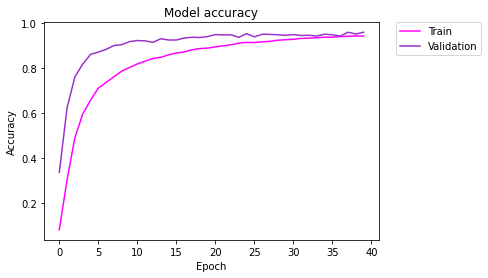

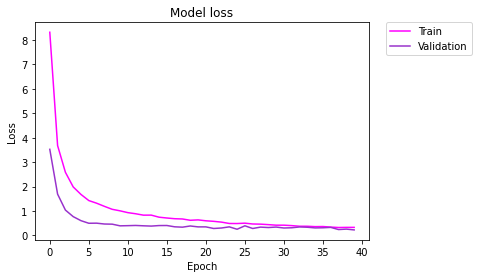

40/40 [==============================] - 4s 92ms/step - loss: 0.2009 - accuracy: 0.9688
Test loss: 0.2008901685476303
Test accuracy: 0.9688000082969666


In [16]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'], color='magenta')
plt.plot(history.history['val_accuracy'], color='darkorchid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'], color='magenta')
plt.plot(history.history['val_loss'], color='darkorchid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'],  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Evaluate against test data.
testVGG19 = model.evaluate(test_generator, verbose=1)
print('Test loss:', testVGG19 [0])
print('Test accuracy:', testVGG19[1])

In [ ]:
predictVGG19 = model.predict(testData)

print(classification_report(testData.classes, tf.argmax(predictVGG19, axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [ ]:
for i, prediction in enumerate(predictVGG19):
    predicted_value = tf.argmax(prediction)
    label = predicted_value.numpy()
    print('Predicted a %d. Real value is %d.' %(predicted_value, testData.classes[i]))

Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 2. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 3. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 6. Real value is 6.
Predicte